# Hypothesis #

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import preprocessing
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings("ignore")

## Этап 0 - загрузка датасета ##

In [21]:
df = pd.read_csv('dataset_after_EDA.csv', engine='python')
df = df.dropna() # в процессе выгрузки датасета после проведения EDA появились пропуски, попробуем найти неисправность
print(df.shape)
df.head()

(4546, 16)


,title,publishedAt,channelTitle,category,trending_date,tags,view_count,likes,comment_count,comments_disabled,ratings_disabled,description,country,subscriber_count,daytime,times_appeared
0,How the Warriors were in the Locker Room after...,2023-05-13 12:48:44,RDCworld1,Sports,2023-05-14,[none],1733159.0,132947.0,5374.0,False,False,Another installment to the Warriors Locker Roo...,United States,6320000.0,1.0,3.0
1,FlightReacts To #6 WARRIORS at #7 LAKERS | FUL...,2023-05-13 06:20:56,FlightReacts,Entertainment,2023-05-14,Reactions|Family|vlog|life|NBA|sports|Friends|...,668981.0,37032.0,3496.0,False,False,Thanks for Tuning In!! Lets Get 5 Million Toge...,United States,4830000.0,1.0,3.0
2,GUESS THE MOM! *Emotional Mother's Day Reveal*,2023-05-13 14:00:07,Jordan Matter,Entertainment,2023-05-14,jordan matter|salish matter|say say matter|bre...,4225973.0,87240.0,11058.0,False,False,Today we reveal my wife for the first time EVE...,United States,15900000.0,1.0,4.0
3,Why Lightbulbs Might Be The Best Invention Ever,2023-05-13 14:06:52,Veritasium,Education,2023-05-14,veritasium|science|physics,1008255.0,65421.0,2934.0,False,False,Lightbulbs might be the best idea ever – just ...,United States,13600000.0,1.0,5.0
4,WATERTOK: The Strangest Community on TikTok,2023-05-12 19:00:20,Kurtis Conner,Comedy,2023-05-14,kurtis conner|kurtis connor|watertok|tiktok|co...,1393152.0,138921.0,9946.0,False,False,The Watertok community on TikTok is really str...,United States,4380000.0,0.0,8.0


Вспомним, какие столбцы содержит наш датасет после предобработки и создания новых признаков

*   `title` - название видео
*   `publishedAt` - время публикации видео, принцип кодирования: "DAY TIME"
    *   DAY - календарный день выпуска видео в формате YYYY-MM-DD
    *   TIME - время в формате HH:MM:SS


*   `channelTitle` - название канала, на котором видео было опубликовано
*   `category` - категория видео

*   `trending_date` - дата, в которую видео попало в список трендов

*   `tags` - теги, прикрепленные автором к видео

*   `view_count` - количество просмотров
*   `likes` - количество лайков
*   `comment_count` - количество комментариев под видео
*   `comments_disabled` - отключены ли под видео комментарии
*   `ratings_disabled` - отключена ли возможность просматривать количество лайков под видео
* `description` - описание видео
* `country` - страна, в чьи тренды попало видео
* `subscriber_count` - количество подписчиков канала
* `daytime` - время суток, в которое было опубликовано видео
    *   0 - видео опубликовано ночью (с 18:00 до 6:00)
    *   1 - видео опубликовано днем (с 6:00 до 18:00)
* `times_appeared` - количество стран, в которых видео попало в тренды

## Этап 1 - гипотеза о схожем распределении показателей `likes` и `subscriber_count` ##

$$
\begin{aligned}
& H_0: f(likes) = f(subscriberCount) \\
& H_1: f(likes) \neq f(subscriberCount)
\end{aligned}
$$

### Шаг 1 - предварительная визуализация ###

На этапе EDA нам показалось интересным то, что столбцы `likes` и `subscriber_count` имеют схожие гистограммы распределения

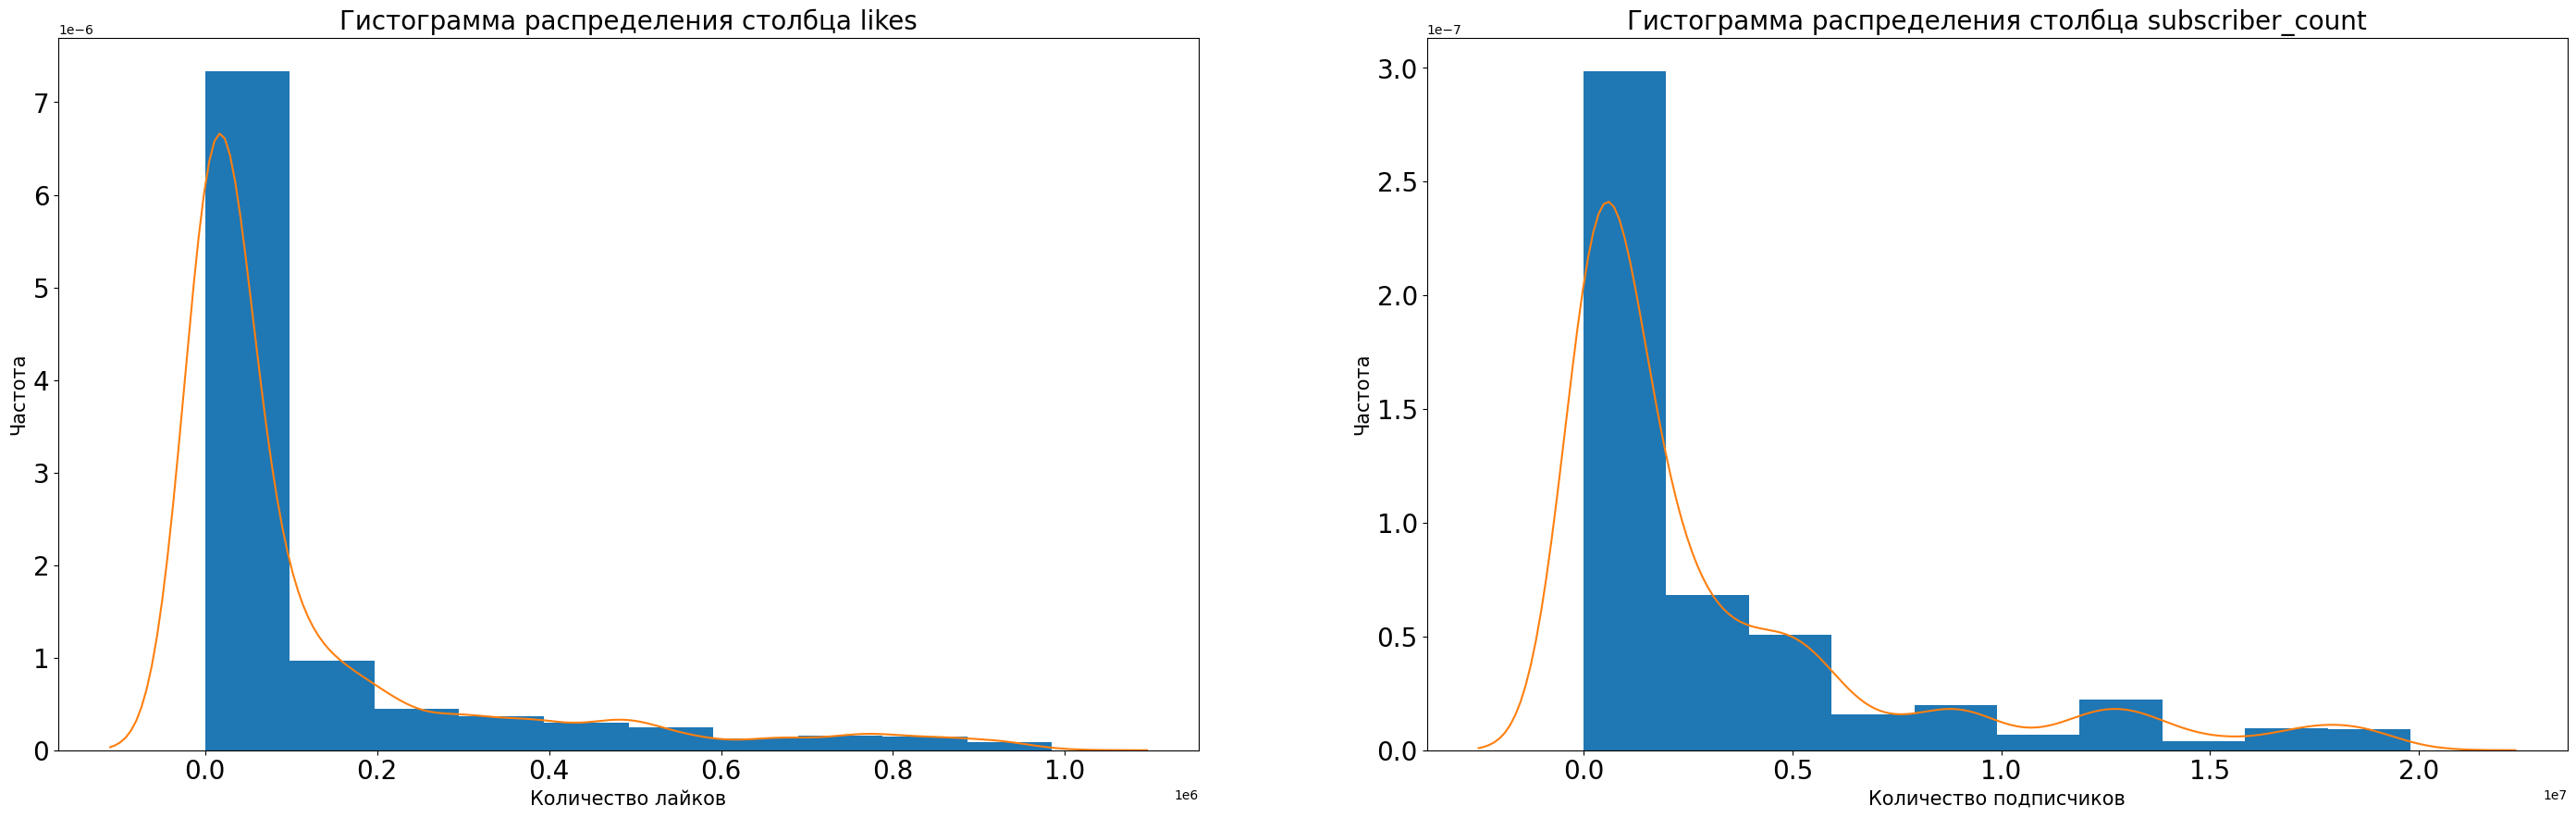

In [22]:
plt.subplots(figsize=(35, 10))

plt.subplot(1, 2, 1)
plt.hist(df['likes'], density = True,)
sns.distplot(df['likes'], hist = False)
plt.tick_params(axis='both', which='major', labelsize = 20)
plt.title('Гистограмма распределения столбца likes', fontsize = 20)
plt.xlabel('Количество лайков', fontsize = 15)
plt.ylabel('Частота', fontsize = 15)

plt.subplot(1, 2, 2)
plt.hist(df['subscriber_count'], density = True)
sns.distplot(df['subscriber_count'], hist = False)
plt.tick_params(axis='both', which='major', labelsize = 20)
plt.title('Гистограмма распределения столбца subscriber_count', fontsize = 20)
plt.xlabel('Количество подписчиков', fontsize = 15)
plt.ylabel('Частота', fontsize = 15);

Действительно, и гистограммы и графики функций плотности являются похожими (не учитывая выбросы столбца `subscriber_count`)

Далее, построим обе функции плотности на одном графике, предварительно отнормировав их с помощью модуля preprocessing из библиотеки sklearn, это необходимо сделать, так как количество лайков и подписчиков сильно различается - подписчиков очевидно больше. Отнормированные данные сохранят все особенности первоначального распределения и позволят более наглядно сравнить графики

In [23]:
likes_scaled = preprocessing.normalize(df['likes'].values.reshape(1, -1))
sub_scaled = preprocessing.normalize(df['subscriber_count'].values.reshape(1, -1))
df_scaled = pd.DataFrame({'likes': likes_scaled[0], 'sub': sub_scaled[0]})

<Figure size 800x600 with 0 Axes>

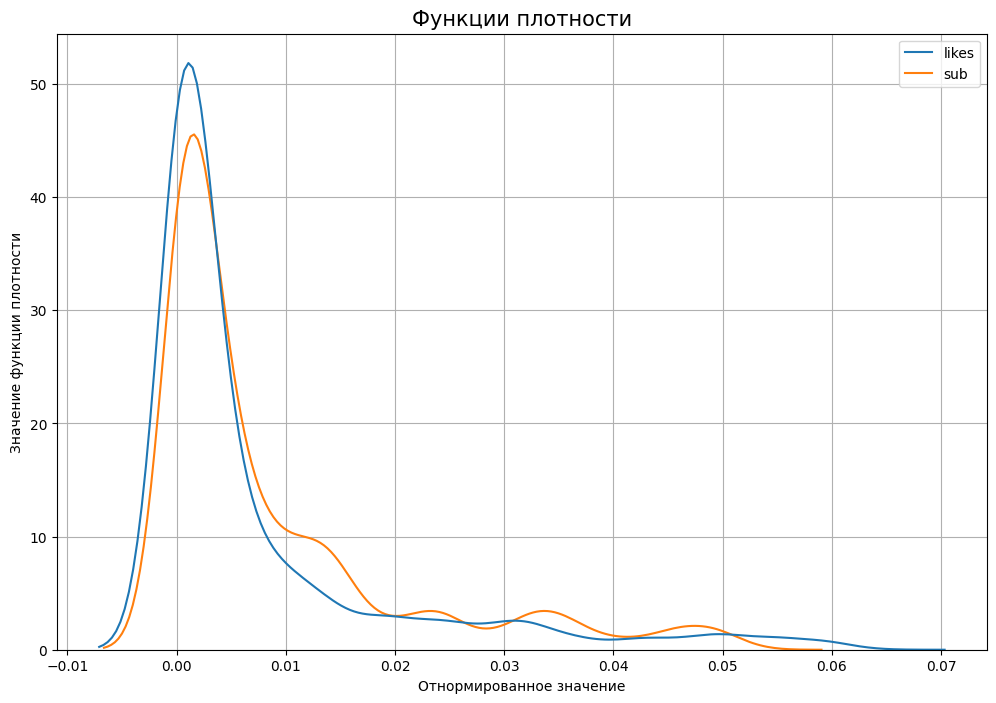

In [24]:
plt.figure(figsize = (8, 6))

fig, ax = plt.subplots(figsize=(12, 8))
ax.grid(which='both')

sns.kdeplot(data = df_scaled, common_norm = True)
plt.title('Функции плотности', fontsize = 15)
plt.xlabel('Отнормированное значение', fontsize = 10)
plt.ylabel('Значение функции плотности', fontsize = 10);

Далее построим кумулятивные функции распределения для столбцов `likes` и `subscriber_count` на одном графике. Используем все те же отнормированные значения

<Figure size 800x600 with 0 Axes>

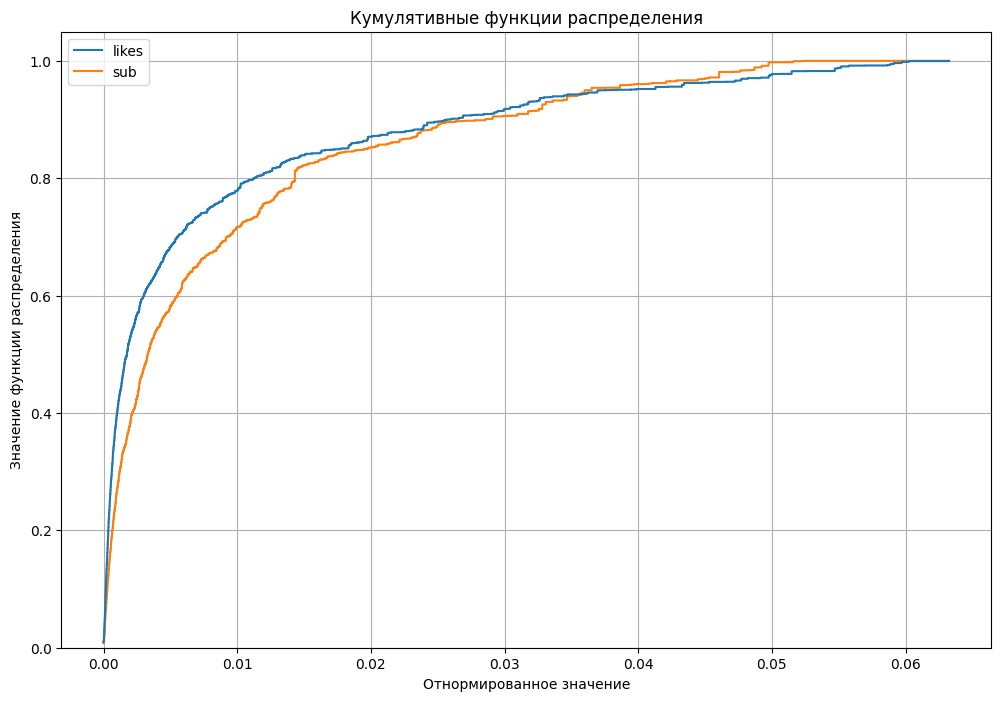

In [25]:
plt.figure(figsize = (8, 6))

fig, ax = plt.subplots(figsize=(12, 8))
ax.grid(which='both')

sns.histplot(data = df_scaled, bins = len(df), stat = "density", element = "step", fill = False, cumulative = True, common_norm = False);
plt.title("Кумулятивные функции распределения")
plt.xlabel('Отнормированное значение', fontsize = 10)
plt.ylabel('Значение функции распределения', fontsize = 10);

Также для визуализации наших распределений воспользуемся графиком скрипичной диаграммы.

Скрипичный график – это сочетание диаграммы размаха и графика плотности, развернутых и расположенных по обе стороны для отображения формы распределения данных.

Отличие от ящика с усами заключается в том, что ящики с усами имеют ограничения в отображении данных, поскольку их визуальная простота скрывает ряд существенных деталей относительно того, каким образом распределяются значения данных. Например, с помощью ящика с усами вы не увидите, какое это распределение - бимодальное (с двумя модами) или мультимодальное (с несколькими модами)

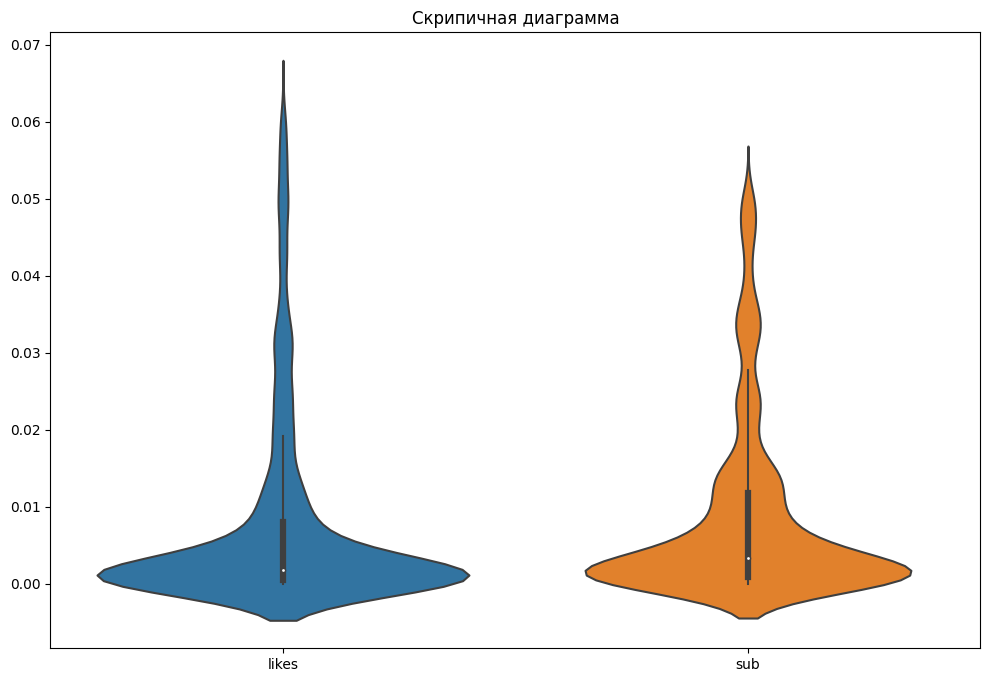

In [26]:
plt.figure(figsize = (12, 8))

sns.violinplot(data=df_scaled)

plt.title("Скрипичная диаграмма");

Действительно, наше предположение о схожести распределений визуально подтверждается, продолжим исследование и проведем т-тест для проверки гипотезы о равенстве средних

### Шаг 2 - проверка гипотезы о равенстве средних с помощью т-теста ###

In [27]:
tCrit = stats.t.ppf(1 - 0.05 / 2, len(df_scaled['likes']) + len(df_scaled['sub']) - 2)
tStat, p_value = ttest_ind(df_scaled['likes'], df_scaled['sub'], alternative = 'two-sided')
tStat

-4.591490130997702

<Figure size 800x600 with 0 Axes>

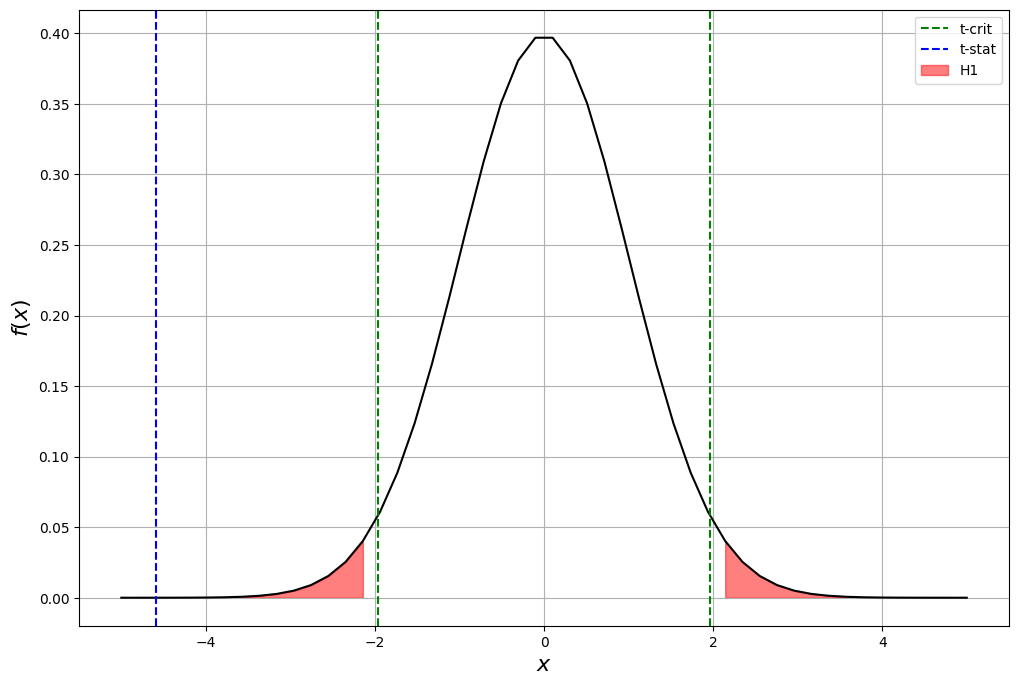

In [28]:
plt.figure(figsize = (8, 6))

fig, ax = plt.subplots(figsize=(12, 8))
ax.grid(which='both')

x = np.linspace(-5, 5)
pdf = stats.t(df = len(df_scaled['likes']) + len(df_scaled['sub']) - 2).pdf(x)

plt.plot(x, pdf, color="black")
plt.ylabel("$f(x)$", fontsize=16)
plt.xlabel("$x$", fontsize=16)

plt.axvline(x = tCrit, color = 'green', linestyle = '--', label = 't-crit')
plt.axvline(x = -tCrit, color = 'green', linestyle = '--')
plt.axvline(x = tStat, color = 'blue', linestyle = '--', label = 't-stat')
plt.fill_between(x, pdf, where = x >= tCrit, color = 'red', alpha = 0.5, label = 'H1')
plt.fill_between(x, pdf, where = x <= -tCrit, color = 'red', alpha = 0.5)

plt.legend(loc = 'upper right');

**Из значения p-value = 0 и графика нашей т-статистики делаем вывод о том, что нулевая гипотеза о равенстве средних показателей `likes` и `subscriber_count` отвергается**

### Шаг 3 - проверка гипотезы об одинаковом распределении с помощью U-критерия Манна — Уитни ###

Далее проверим нулевую гипотезу о том, что наши переменные имеют одинаковое распределение. Сделаем это через U-критерий Манна — Уитни, который сравнивает среднее двух распределений.

В отличие от т-теста, U-критерий Манна — Уитни не зависит от выбросов и концентрируется на центре распределения.

In [29]:
stat, p_val = stats.mannwhitneyu(df_scaled['likes'], df_scaled['sub'], alternative='two-sided')
round(p_val, 4)

0.0

**В результате получаем значение p-value равное 0, наша нулевая гипотеза об одинаковом среднем двух распределений отвергается при любом уровне значимости**

### Шаг 4 - проверка гипотезы об одинаковом распределении с помощью теста Колмогорова - Смирнова ###

Идея критерия Колмогорова — Смирнова — сравнить кумулятивные распределения двух групп. В частности, статистика теста Колмогорова — Смирнова представляет собой максимальную абсолютную разницу между двумя кумулятивными распределениями.

In [30]:
stat, p_val = stats.ks_2samp(df_scaled['likes'], df_scaled['sub'])
round(p_val, 4)

0.0

**В результате получаем значение p-value равное 0, наша нулевая гипотеза об одинаковом распределении отвергается при любом уровне значимости**

### Шаг 5 - суммарный результат всех тестирований ###

Итак, проведя три различных тестирования - т-тест, U-критерий Манна — Уитни и тест Колмогорова - Смирнова, получаем абсолютно одинаковый результат - несмотря на визуальную схожесть, переменные `likes` и `subscriber_count` подчиняются разным распределениям.

## Этап 2 - гипотеза о различии среднего количества просмотров между разными категориями видео ##

$$
\begin{aligned}
& H_0: \mu_{category_i} = \mu_{category_j} \\
& H_1: \mu_{category_i} \neq \mu_{category_j}
\end{aligned}
$$

Так как рассматриваемых выборок у нас явно больше двух и все они разных размеров, используем тест Краскела-Уоллиса.

Критерий Краскела-Уоллиса - это непараметрическая альтернатива одномерному дисперсионному анализу. Он используется для сравнения трех или более выборок, и проверяет нулевые гипотезы, согласно которым различные выборки были взяты из одного и того же распределения, или из распределений с одинаковыми средними.

Во время выполнения визуализаций на шаге EDA мы заметили, что категории `Comedy`, `Entertainment` и `Sports` имеют приблизительно одинаковый средний уровень просмотров, именно поэтому мы решили взять в рассмотрение эти категории

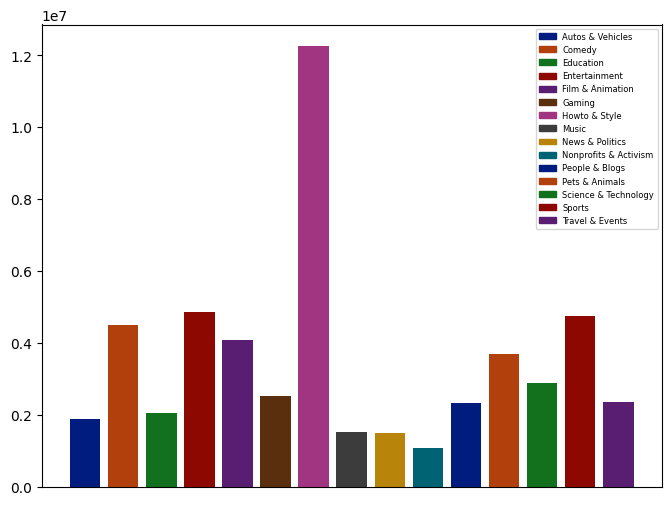

In [31]:
tempViews = df.groupby(['category']).agg({'view_count': 'mean'})

x = tempViews.index
colors = sns.color_palette('dark', 15)

fig, axes = plt.subplots(figsize=(8, 6))

plt.bar(x, tempViews['view_count'], color = colors)
ax.set_title('Количество просмотров')
plt.xticks([])
patches = [mpatches.Patch(color=colors[i], label=x[i]) for i in range(len(x))]
plt.legend(handles=patches, prop={'size': 6}, loc='upper right')
ax.set_xlabel('Категория', fontsize = 10)
ax.set_ylabel('Частота', fontsize = 10);

In [32]:
data1 = df[df['category'] == 'Comedy']['view_count']
data2 = df[df['category'] == 'Entertainment']['view_count']
data3 = df[df['category'] == 'Sports']['view_count']

len(data1), len(data2), len(data3)

(312, 1317, 507)

Подготовив три выборки разного размера приступаем к тестированию гипотезы с помощью функции kruskal из библиотеки stats

In [33]:
stat, p_val = stats.kruskal(data1, data2, data3)
round(p_val, 2)

0.06

**В результате тестирования получаем значение p-value = 0.06, что больше заданного уровня значимости в 5% - нулевая гипотеза о различии среднего количества просмотров между разными категориями видео не отвергается**

## Этап 3 - гипотеза о различии среднего количества лайков между видео с включенными и выключенными комментариями ##

$$
\begin{aligned}
& H_0: \mu_{likes_+} = \mu_{likes_-} \\
& H_1: \mu_{likes_+} \neq \mu_{likes_-}
\end{aligned}
$$

Проверим гипотезу через U-критерий Манна — Уитни, который сравнивает среднее двух распределений.

В отличие от т-теста, U-критерий Манна — Уитни не зависит от выбросов и концентрируется на центре распределения.

In [34]:
data1 = df[df['comments_disabled'] == 'True']['likes']
data2 = df[df['comments_disabled'] == 'False']['likes']

len(data1), len(data2)

(84, 4462)

In [35]:
stat, p_val = stats.mannwhitneyu(data1, data2, alternative='two-sided')
round(p_val, 4)

0.0001

**По результатам теста получаем значение p-value < 0.05 - нулевая гипотеза об отсутствии различия среднего количества лайков между видео с включенными и выключенными комментариями отвергается на уровне значимости 5%**

## Этап 4 - гипотеза о влиянии времени публикации видео на количество просмотров ##

$$
\begin{aligned}
& H_0: \textit{Время публикации видео не влияет на количество просмотров} \\
& H_1: \textit{Время публикации видео влияет на количество просмотров}
\end{aligned}
$$

Данную гипотезу проверим с помощью регрессионного анализа. Для этого обучим модель линейной регрессии: в качестве целевой переменной определим столбец `view_count`, в качестве вспомогательной - `daytime`

In [36]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)

X_train = np.array(df_train['daytime']).reshape(-1, 1)
X_test = np.array(df_test['daytime']).reshape(-1, 1)

y_train = np.array(df_train['view_count']).reshape(-1, 1)
y_test = np.array(df_test['view_count']).reshape(-1, 1)

После подготовки всех данных, разделения выборки на тестовую и тренировочную мы готовы приступить к процессу обучения модели и получения предсказаний первого класса

In [37]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

Далее изучим коэффициент нашей регрессии, который соответствует времени публикации видео. Если коэффициент значимо отличен от нуля, это может свидетельствовать о наличии влияния времени публикации на количество просмотров.

In [38]:
model.coef_[0][0]

-432068.43116843613

Получаем довольно большое отрицательное значение коэффициента регрессии при переменной `daytime`. Это говорит о сильной зависимости количества просмотров от времени публикации видео - ролики, опубликованные в промежутке между 18:00 и 6:00, набирают больше просмотров. **Значит, нулевая гипотеза, в котрой утверждается, что время публикации видео не влияет на количество просмотров, не отвергается.**

## Этап 5 - результаты ##

Итак, нами было проверено 4 гипотезы:

1.   **Гипотеза о схожем распределении показателей `likes` и `subscriber_count`.**

> После построения графиков распределения двух переменных: гистограмм, функций плотности, кумулятивных функций распределения и скрипичных диаграмм, мы приходим к выводу о визуальной схожести двух переменных. три различных тестирования - т-тест, U-критерий Манна — Уитни и тест Колмогорова - Смирнова, получаем абсолютно одинаковый результат - несмотря на внешнюю схожесть, переменные `likes` и `subscriber_count` подчиняются разным распределениям.

2. **Гипотеза о различии среднего количества просмотров между разными категориями видео.**

> В силу большого количества выборок и их разницы в размерах, мы прибегли к помощи критерия Краскела-Уоллиса, непараметрической альтернативы одномерному дисперсионному анализу, проверили категории `Comedy`, `Entertainment` и `Sports` на равенство количества просмотров. В результате нулевая гипотеза подтвердилась - рассматриваемые категории имеют одинаковое среднее количество просмотров

3. **Гипотеза о различии среднего количества лайков между видео с включенными и выключенными комментариями.**

> Данную гипотезу мы тестировали через U-критерий Манна — Уитни, который сравнивает среднее двух распределений. Мы предпочли именно этот метод т-тесту, так как в отличие от т-теста, U-критерий Манна — Уитни не зависит от выбросов и концентрируется на центре распределения. По результатам тестирования получаем, что нулевая гипотеза об отсутствии различия среднего количества лайков между видео с включенными и выключенными комментариями отвергается.

4. **Гипотеза о влиянии времени публикации видео на количество просмотров.**

> Данную гипотезу мы проверили с помощью регрессионного анализа. Для этого нами была обучена модель линейной регрессии: в качестве целевой переменной использован столбец `view_count`, в качестве вспомогательной - `daytime`. Дальше мы взгялнули на полученный коэффициент регрессии обученной модели, он свидетельствует о сильной зависимости количества просмотров от времени публикации видео - ролики, опубликованные в промежутке между 18:00 и 6:00, набирают больше просмотров. Значит, нулевая гипотеза, в котрой утверждается, что время публикации видео не влияет на количество просмотров, не отвергается.

